# Notebook Setup

### Importing Required Libraries

In [3]:
import sys

sys.path.append("./../..")

from numba import jit
from numba.types import bool_, int_
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit
from scipy.stats import moment
from time import time

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import torch

### Defining Support Functions

In [4]:
@jit
def RunTumble(param, dt=0.01, TotalT=1):
    k = param[:,0]
    omega = param[:,1]
    D = param[:,2]
    alpha = param[:,3]
    
    n_sim = len(k)
    
    total_time_steps = np.int64(TotalT / dt)
    
    x = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, total_time_steps))
    
    direction = np.ones((1, n_sim))
    
    for n in range(1, total_time_steps):
        change = np.random.uniform(0, 1, size=(1, n_sim)) < alpha * dt / 2 # Change direction with probability alpha*dt/2
        change = -(change *2 -1) # From boolean to -1 or 1 (false = 1, true = -1)
        direction = change*direction # Change direction if change is true
        nu = np.random.normal(0, 1, size=(1, n_sim))
        x[:] = x[:] + (-k * x[:] + omega * direction) * dt + np.sqrt(2 * D * dt) * nu
        x_trace[:, n] = x[:,]

    return x_trace

def GenerateRawData(n_sim, prior_limits, simulator_param, simulator, test = False, prior_input = None):
    """
    n_sim: int - number of simulations to run
    prior_limits: dictionary - dictionary with the limits of the prior for each parameter
    simulator_param: dictionary - Parameters to pass to the simulator: dt, TotalT
    simulator: function - RunTumble Simulator defined above
    test: bool - If True, the same parameter set is used for all simulations
    prior_input: torch.distribution - If not None, this is the prior used to generate the data. Effectively, this is the posterior from the previous round
    
    RETURNS
    
    theta: torch.tensor - Parameter set used to generate the data
    raw_trace: numpy array - Raw data generated
    prior: torch.distribution - Prior used to generate the data
    """
    
    
    # Define the number of parameters
    NumberOfParameters = len(prior_limits)
    
    # From prior dictionary to numpy array
    BoxLimits = np.zeros((4, NumberOfParameters))
    i = 0
    for item in prior_limits.items():
        BoxLimits[0, i] = item[1][0]
        BoxLimits[1, i] = item[1][1]
        i +=1
    BoxLimits = torch.tensor(BoxLimits)
    # Define the prior as a uniform box for each parameter
    prior = utils.BoxUniform(low=BoxLimits[0], high=BoxLimits[1])
    
    if prior_input is not None:
        prior = prior_input
    # Generate the data
    theta = prior.sample((n_sim,))
    if test:
        theta = torch.tensor([list(theta[0].numpy())]*n_sim)
    raw_trace = simulator(param = theta.numpy(), **simulator_param)

    return theta, raw_trace, prior

def ComputeSummaryStatistics(summary_statistics_to_calculate, raw_trace, available_statistics = {}, hyperparameters = {}, verbose = True):
    """
    summary_statistics_to_calculate: list - List of strings with the names of the summary statistics to calculate
    raw_trace: numpy array - Raw data to calculate the summary statistics from. Ideally output from "GenerateRawData"
    available_statistics: dictionary - Dictionary with the available summary statistics to calculate. The keys are the names of the statistics and the values are the functions that calculate them
    hyperparameters: dictionary - Dictionary with the hyperparameters to pass to the summary statistics functions (Passed to all summary statistics!!)
    verbose: bool - If True, print the name of the summary statistic being calculated
    
    RETURNS
    
    final_vector: torch.tensor - Vector with the summary statistics calculated in the order they were requested, ready to be passed to SBI
    """
    
    
    ## summary_statistics_to_calculate is a list of strings with the names of the summary statistics to calculate
    ## raw_trace is a numpy array with the raw data
    
    
    # Calculate the summary statistics
    final_vector = torch.zeros(0)
    for stat in summary_statistics_to_calculate:
        if verbose:
            print(f"Computing {stat}...")
        final_vector = torch.cat((final_vector, torch.tensor(available_statistics[stat](raw_trace, hyperparameters = hyperparameters))))
    
    return final_vector

def SBIPipeline(prior_limits, simulator_param, summary_statistics_to_calculate, available_statistics, hyperparameters, n_sim = 1000, n_rounds = 3):
    """
    prior_limits: dictionary - Dictionary with the limits of the prior for each parameter
    simulator_param: dictionary - Parameters to pass to the simulator: dt, TotalT
    summary_statistics_to_calculate: list - List of strings with the names of the summary statistics to calculate
    available_statistics: dictionary - Dictionary with the available summary statistics to calculate. The keys are the names of the statistics and the values are the functions that calculate them
    hyperparameters: dictionary - Dictionary with the hyperparameters to pass to the summary statistics functions (Passed to all summary statistics!!)
    n_sim: int - number of simulations to run
    n_rounds: int - Number of inference rounds to run
    
    RETURNS
    posterior: torch.distribution - Posterior distribution
    theta_test: torch.tensor - Test parameter set
    stats_test: torch.tensor - Test summary statistics
    """
    
    
    # Generate the raw data
    start = time()
    theta, raw_trace, prior = GenerateRawData(n_sim, prior_limits, simulator_param, RunTumble)
    data_time = time()
    print(f"Time to generate data: {data_time - start:.2f}s")
    stats = ComputeSummaryStatistics(summary_statistics_to_calculate, raw_trace, available_statistics, hyperparameters);
    stat_time = time()
    print(f"Time to compute summary statistics: {stat_time-data_time:.2f}s")
    stats = stats.float()
    # Set up SBI
    prior, num_parameters, prior_returns_numpy = process_prior(prior)
    infer = SNPE(prior=prior)
    
    inference = infer.append_simulations(theta, stats, proposal=prior)
    density_estimator = inference.train()
    posterior = inference.build_posterior(density_estimator)
    train_time = time()
    print(f"Time to train: {train_time - stat_time:.2f}s")
    n_test = 1
    theta_test, trace_test, prior = GenerateRawData(n_test, prior_limits, simulator_param, RunTumble)
    stats_test = ComputeSummaryStatistics(summary_statistics_to_calculate, trace_test, available_statistics, hyperparameters, verbose = False);
    
    posterior = posterior.set_default_x(stats_test)
    
    
    if n_rounds > 1:
        print("Starting additional rounds...")
        for i in range(n_rounds-1):
            print(f"Round {i+2}")
            print("Generating data...\r", end="")
            theta, raw_trace, prior = GenerateRawData(n_sim, prior_limits, simulator_param, RunTumble, prior_input = posterior)
            print("Computing summary statistics...\r", end = "")
            stats = ComputeSummaryStatistics(summary_statistics_to_calculate, raw_trace, available_statistics, hyperparameters);
            stats = stats.float()
            inference = inference.append_simulations(theta, stats, proposal=prior)
            density_estimator = inference.train()
            posterior = inference.build_posterior(density_estimator)
            posterior = posterior.set_default_x(stats_test)
            print("Round complete                              \r", end = "")
    
    return posterior, theta_test, stats_test

### Define Summary Statistics Functions

In [5]:
def Autocorrelation(multiple_raw_traces, hyperparameters = {}):
    """
    multiple_raw_traces: numpy array - Array with the raw traces to calculate the autocorrelation from
    hyperparameters: dictionary - Currently implementend hyperparameters are: DeltaT, sampling, n_points
    """
    if "DeltaT" in hyperparameters.keys():
        DeltaT = hyperparameters["DeltaT"]
    else:
        print("No DeltaT provided, assuming DeltaT = 1")
        DeltaT = 1
        
    if "sampling" in hyperparameters.keys():
        sampling = hyperparameters["sampling"]
    else:
        print("No sampling provided, assuming linear")
        sampling = "linear"
    
    if "n_points" in hyperparameters.keys():
        n_points = hyperparameters["n_points"]
    else:
        print("No n_points provided, assuming 100")
        n_points = 100
    
    
    autocorr = stat_corr_single(multiple_raw_traces[0,:], 1) .reshape(1,-1)
    for i in np.arange(1,multiple_raw_traces.shape[0]):
        autocorr = np.vstack((autocorr, stat_corr_single(multiple_raw_traces[i,:], DeltaT)))
        
    if sampling == "linear":
        autocorr = autocorr[:,np.linspace(0,autocorr.shape[1]-1,n_points).astype(int)]
    elif sampling == "log":
        autocorr = autocorr[:,np.logspace(0,np.log10(autocorr.shape[1]-1),n_points).astype(int)]
    elif sampling == "fit":
        autocorr = FitAutocorrelationFunctions(autocorr, DeltaT)
    elif sampling == "all":
        pass
    return autocorr

def FitAutocorrelationFunctions(multiple_corr_traces, DeltaT, function = None, n_param = 0):
    """
    Fit an exponential function to the autocorrelation functions with formula a*exp(-b*x)
    
    If custom function is specified, the function must be of the form function(x, a, b, c, ...) and n_param must be the number of parameters
    """
    if function is None:
        n_param = 3
        def function(x, a, b, c):
            return a * np.exp(-b * x) + c
    if function == "DoubleExp":
        n_param = 5
        def function(x, a, b, c, d, e):
            return a * np.exp(-b * x) + c*np.exp(-d*x) + e
    
    if function == "DampedOscillator":
        n_param = 5
        def function(x, a, b, c, d, e):
            return a*np.exp(-b*x)*np.cos(c*x + d) + e
    
    if callable(function):
        pass
    
    
    output = np.zeros((multiple_corr_traces.shape[0], n_param))
    for i in range(multiple_corr_traces.shape[0]):
        x = np.arange(0,multiple_corr_traces.shape[1]*DeltaT, DeltaT)
        popt, pcov = curve_fit(function, x, multiple_corr_traces[i,:], maxfev = 100_000)
        output[i,:] = popt
    return output
    
def TheoreticalAutocorrelation(D, k, alpha, omega, t, t1):
    return np.exp(-k (t - t1)) * ((D/k) * (1 - np.exp(-2*k*t1)) +2*omega**2*(np.exp(-2*k*t1) * 1/(2 * k *(k-alpha))) + np.exp(-(k+alpha)*t1)*1/((k+alpha)*(alpha-k)) + 1/(2*k*(k + alpha))) + omega/(k + alpha) * (1 - np.exp(-(k+alpha)*(t-t1))) * (omega / (k + alpha) * (1 - np.exp(-(k+alpha)*t1)))

------
# Sample Usage

### Generate Raw Data

In [6]:
### Define important variables ###

prior_limits = {"k" : [0,5], "omega": [0,5], "D": [0,5], "alpha": [0,1]}
simulator_param = {"dt":0.001, "TotalT":10}
summary_statistics_to_calculate = ["Autocorrelation"]
available_statistics = {"Autocorrelation": Autocorrelation}
hyperparameters = {"DeltaT":0.001, "sampling":"fit", "n_points":100,"function":"DampedOscillator"}
n_sim = int(1e4)
t = np.arange(0, simulator_param["TotalT"], simulator_param["dt"])

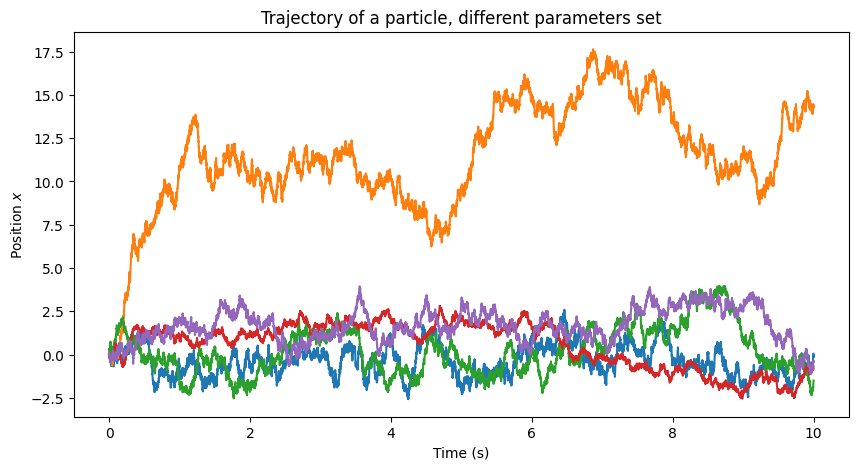

In [8]:
### Generate data ###

theta, raw_trace, prior = GenerateRawData(n_sim, prior_limits, simulator_param, RunTumble) # Should run in less than 5s on my machine - J
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position $x$")
ax.set_title("Trajectory of a particle, different parameters set")

for i in range(5):
    ax.plot(t, raw_trace[i, :]);

Parameter set used:  [1.6113764 3.1933358 2.7018344 0.5473976]


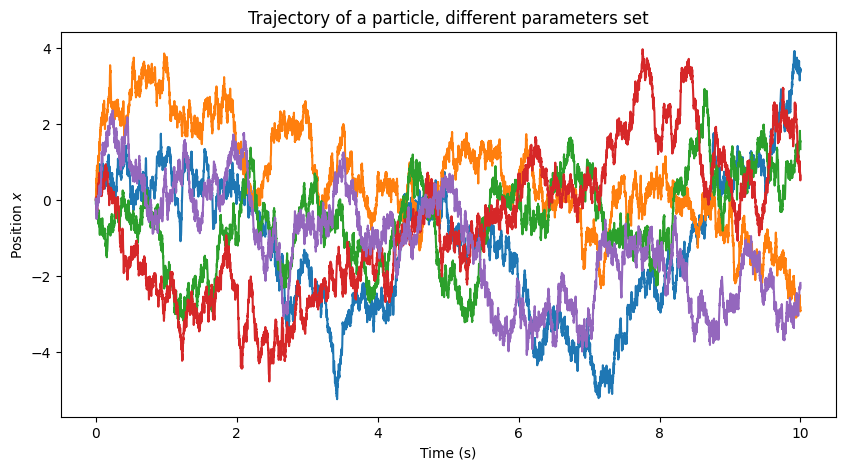

In [11]:
### How to use the test variable to generate with the same parameter set ###
theta, raw_trace, prior = GenerateRawData(n_sim, prior_limits, simulator_param, RunTumble, test=True) # Should run in less than 5s on my machine - J
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position $x$")
ax.set_title("Trajectory of a particle, different parameters set")

for i in range(5):
    ax.plot(t, raw_trace[i, :])
    
print("Parameter set used: ", theta[0].numpy())

### Calculate Summary Statistics

In [23]:
### Define important variables ###

prior_limits = {"k" : [0,5], "omega": [0,5], "D": [0,5], "alpha": [0,1]}
simulator_param = {"dt":0.001, "TotalT":10}
summary_statistics_to_calculate = ["Autocorrelation"]
available_statistics = {"Autocorrelation": Autocorrelation}
hyperparameters = {"DeltaT":0.001, "sampling":"all", "n_points":100}
n_sim = int(1e3)
t = np.arange(0, simulator_param["TotalT"], simulator_param["dt"])

Available samplings:
- `fit` : Fit the data with "function" and return the parameters
- `log` : Log Sampling
- `linear` : Linear Sampling
- `all` : keep all data


Available fit functions:
- If "function" is not set, the default is `expon` (Exponential Distribution)
- "DoubleExp" : Double Exponential Distribution
- "DampedOscillator" : Damped Oscillation

In [26]:
### Generate data ###
theta, raw_trace, prior = GenerateRawData(n_sim, prior_limits, simulator_param, RunTumble, test = True) # Notice that we are using the same parameter set for all simulations

### Calculate summary statistics ###
stats = ComputeSummaryStatistics(summary_statistics_to_calculate, raw_trace, available_statistics, hyperparameters) # Entire Cell should run in less than 30s -J

# Can encounter overflow errors

Computing Autocorrelation...


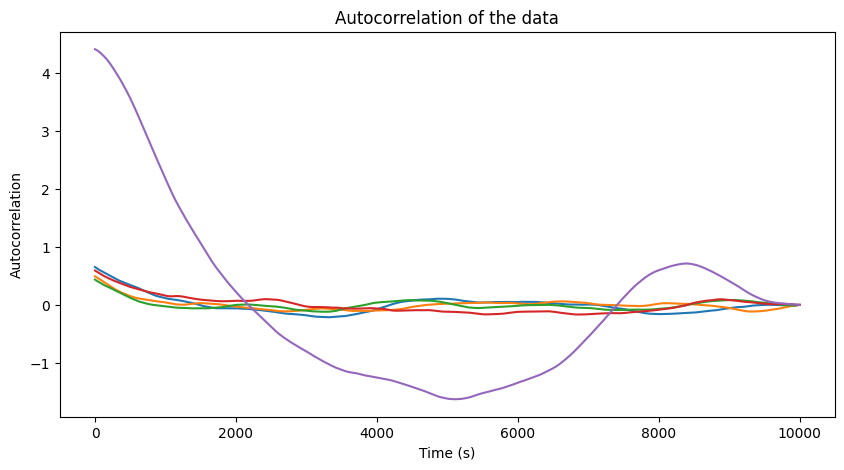

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation of the data")

for i in range(5):
    ax.plot(stats[i,:])

### SBI

In [29]:
### Define important variables ###

prior_limits = {"k" : [0,5], "omega": [0,5], "D": [0,5], "alpha": [0,1]}
simulator_param = {"dt":0.001, "TotalT":10}
summary_statistics_to_calculate = ["Autocorrelation"]
available_statistics = {"Autocorrelation": Autocorrelation}
hyperparameters = {"DeltaT":0.001, "sampling":"fit", "n_points":100}
n_sim = int(1e3) # Only using 1000 simulations for speed, check that this value is a int!
t = np.arange(0, simulator_param["TotalT"], simulator_param["dt"])
n_rounds = 1 # We are doing only one round!

In [30]:
posterior,theta_test,stats_test = SBIPipeline(prior_limits, simulator_param, summary_statistics_to_calculate, available_statistics, hyperparameters, n_sim = n_sim, n_rounds=n_rounds);

Time to generate data: 0.29s
Computing Autocorrelation...


/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_62243/3258215692.py:48: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_62243/3258215692.py:48: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


Time to compute summary statistics: 12.67s
 Neural network successfully converged after 127 epochs.Time to train: 10.34s


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

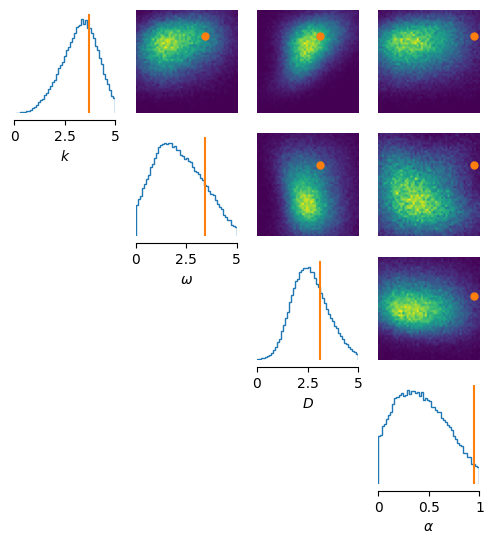

In [31]:
samples = posterior.sample((100000,), x=stats_test)
_ = analysis.pairplot(samples, points=theta_test, figsize=(6, 6),limits=[[0,5],[0,5],[0,5],[0,1]], labels=[r"$k$", r"$\omega$", r"$D$", r"$\alpha$"])

Time to generate data: 0.23s
Computing Autocorrelation...


/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_62243/3258215692.py:48: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_62243/3258215692.py:48: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


Time to compute summary statistics: 12.92s
 Neural network successfully converged after 122 epochs.Time to train: 9.31s
Starting additional rounds...
Round 2


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing Autocorrelation......
Using SNPE-C with atomic loss
Round 3 network successfully converged after 22 epochs.Round complete                              


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing Autocorrelation......
Using SNPE-C with atomic loss


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

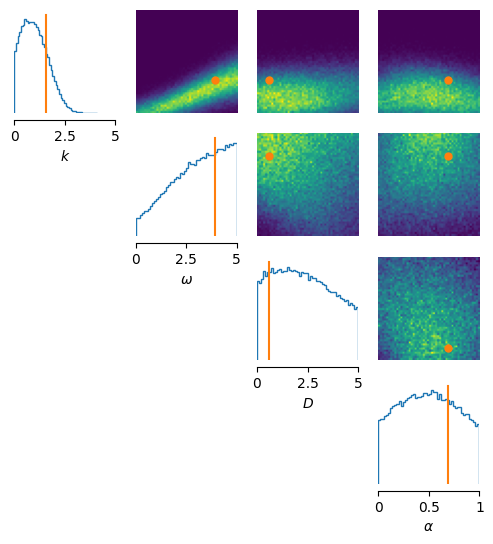

In [35]:
### Multiple Rounds ###
posterior,theta_test,stats_test = SBIPipeline(prior_limits, simulator_param, summary_statistics_to_calculate, available_statistics, hyperparameters, n_sim = n_sim, n_rounds=3);
samples = posterior.sample((100000,), x=stats_test)
_ = analysis.pairplot(samples, points=theta_test, figsize=(6, 6),limits=[[0,5],[0,5],[0,5],[0,1]], labels=[r"$k$", r"$\omega$", r"$D$", r"$\alpha$"])

-------
# Correlation

### Dampened Oscillator

No n_points provided, assuming 100


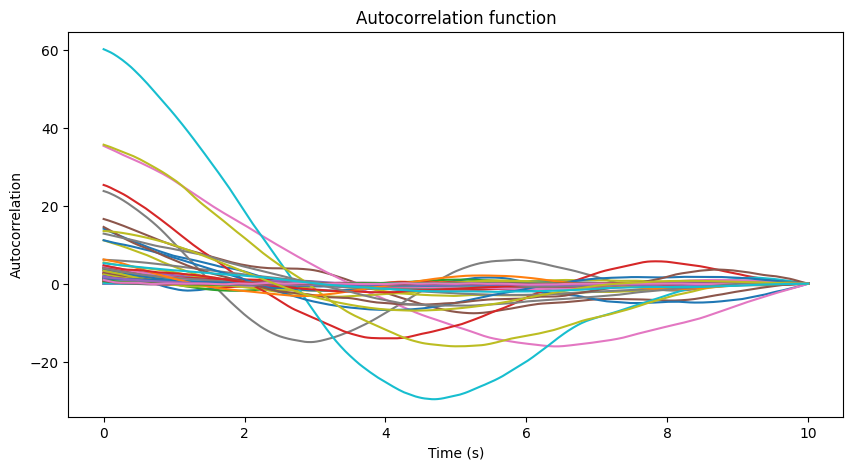

In [32]:
theta, raw_trace, prior = GenerateRawData(100, prior_limits, simulator_param, RunTumble)
CXX = Autocorrelation(raw_trace, hyperparameters = {"DeltaT":0.001, "sampling":"all"})
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation function")
for i in range(100):
    ax.plot(t[:CXX.shape[1]], CXX[i, :]);

No n_points provided, assuming 100


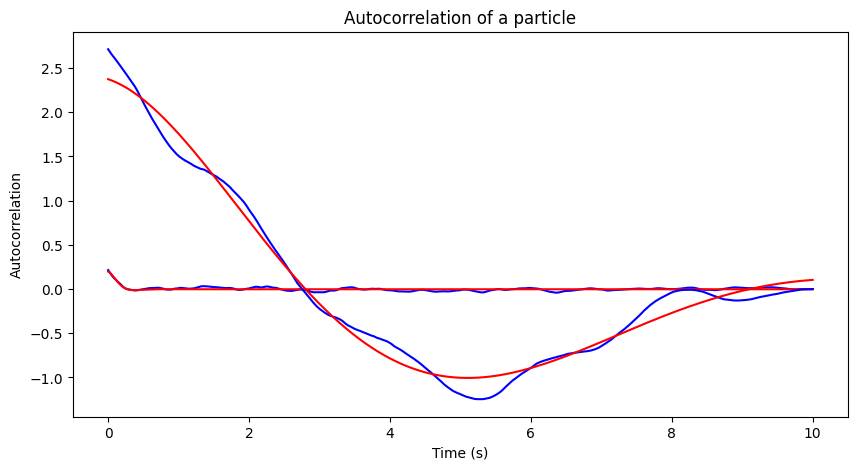

In [33]:
cxx = Autocorrelation(raw_trace[0:100], {"DeltaT":0.001, "sampling":"all"})
cxx_fit = FitAutocorrelationFunctions(cxx, hyperparameters["DeltaT"], function = "DampedOscillator")

def function(x, a, b, c, d,e):
    return a*np.exp(-b*x)*np.cos(c*x + d) + e

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation of a particle")

for i in range(2):
    ax.plot(np.arange(0, cxx.shape[1]*hyperparameters["DeltaT"], hyperparameters["DeltaT"]), cxx[i,:], label = "Data", color = "blue")
    ax.plot(np.arange(0, cxx.shape[1]*hyperparameters["DeltaT"], hyperparameters["DeltaT"]), function(np.arange(0, cxx.shape[1]*hyperparameters["DeltaT"], hyperparameters["DeltaT"]), *cxx_fit[i,:]), label = "Fit", color = "red");

### Stability of Dampened Fit

In [22]:
######## WARING: This cell will take a long time to run! ########



simulator_param = {"dt":0.001, "TotalT":10}
theta, raw_trace, prior = GenerateRawData(10000, prior_limits, simulator_param, RunTumble, test=True)
CXX = Autocorrelation(raw_trace, hyperparameters = {"DeltaT":0.001, "sampling":"all"})
cxx_fit = FitAutocorrelationFunctions(CXX, hyperparameters["DeltaT"], function = "DampedOscillator")
means = np.mean(cxx_fit, axis = 0)
stds = np.std(cxx_fit, axis = 0)
for i in range(5):
    print(f"Parameter {i}: {means[i]:.2f} +/- {stds[i]:.2f}")

No n_points provided, assuming 100
Parameter 0: 1.89 +/- 0.84
Parameter 1: 1.84 +/- 0.84
Parameter 2: 0.41 +/- 0.82
Parameter 3: 0.36 +/- 0.78
Parameter 4: -0.02 +/- 0.01
